Simple Mobile Edge Caching problem


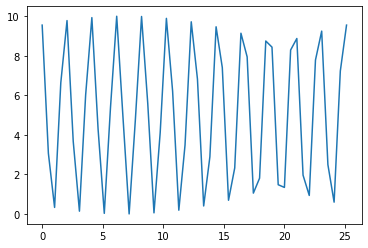

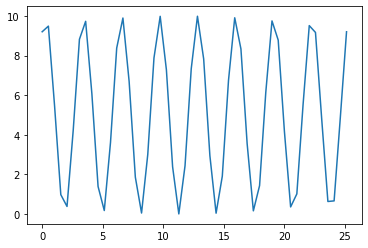

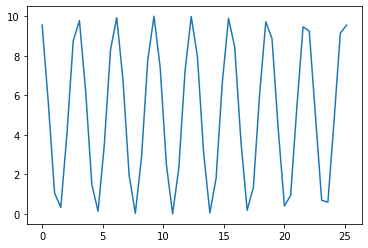

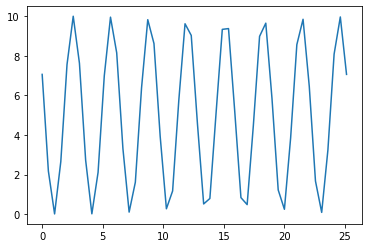

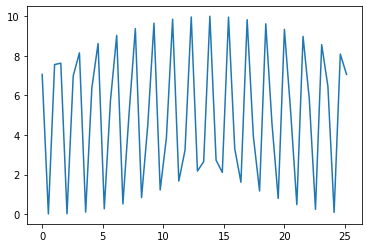

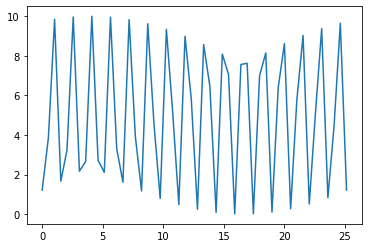

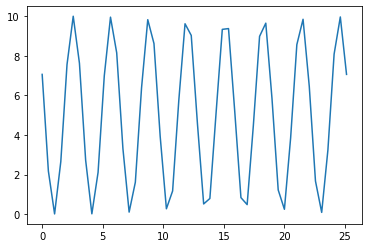

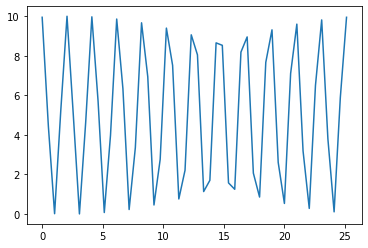

[[9 9 9 7 7 1 7 9]
 [3 9 5 2 0 3 2 4]
 [0 5 1 0 7 9 0 0]
 [6 0 0 2 7 1 2 5]
 [9 0 4 7 0 3 7 9]
 [3 4 8 9 6 9 9 5]
 [0 8 9 7 8 2 7 0]
 [6 9 6 2 0 2 2 4]
 [9 6 1 0 6 9 0 9]
 [4 1 0 2 8 2 2 5]
 [0 0 3 6 0 2 6 0]
 [5 3 8 9 5 9 9 3]
 [9 8 9 8 9 3 8 9]
 [4 9 6 3 0 1 3 6]
 [0 6 1 0 5 9 0 0]
 [4 1 0 1 9 3 1 3]
 [9 0 2 6 0 1 6 9]
 [5 3 7 9 4 9 9 6]
 [0 7 9 8 9 4 8 0]
 [4 9 7 3 1 0 3 2]
 [9 7 2 0 3 9 0 9]
 [6 2 0 1 9 5 1 7]
 [0 0 2 5 1 0 5 0]
 [3 2 7 9 3 8 9 2]
 [9 7 9 9 9 5 9 9]
 [6 9 7 4 2 0 4 8]
 [0 7 3 0 2 8 0 1]
 [2 2 0 0 9 6 0 1]
 [9 0 1 5 2 0 5 8]
 [7 1 6 9 2 8 9 8]
 [0 6 9 9 9 7 9 1]
 [2 9 8 5 3 0 5 1]
 [9 8 3 0 1 7 0 8]
 [7 3 0 0 9 7 0 8]
 [1 0 1 4 3 0 4 2]
 [1 1 6 8 1 6 8 0]
 [8 6 9 9 9 8 9 7]
 [8 9 8 5 4 0 5 9]
 [1 8 4 1 0 6 1 2]
 [1 4 0 0 9 8 0 0]
 [8 0 0 3 5 0 3 7]
 [8 1 5 8 0 5 8 9]
 [1 5 9 9 8 9 9 3]
 [0 9 9 6 5 0 6 0]
 [7 9 4 1 0 5 1 6]
 [9 4 0 0 8 9 0 9]
 [2 0 0 3 6 0 3 3]
 [0 0 4 8 0 4 8 0]
 [7 4 9 9 8 9 9 5]
 [9 9 9 7 7 1 7 9]]
0
1
5
4
0
3
2
1
0
4
3
3
0
1
5
4
0
3
2
1
0
4
3
3
0

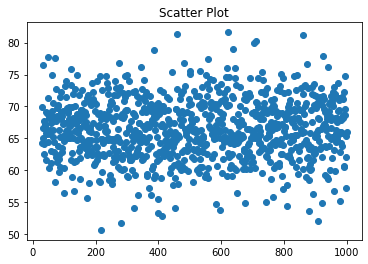

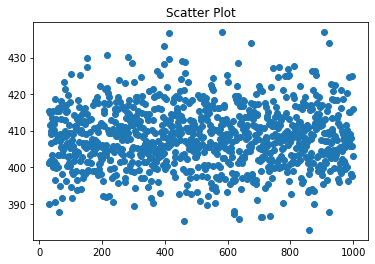

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import gym_hy1
from pdb import set_trace as debug
import matplotlib.pyplot as plt

# Hyper Parameters
BATCH_SIZE = 32
#BATCH_SIZE = 64
LR = 0.001                   # learning rate
EPSILON = 0.99              # greedy policy
GAMMA = 0.9                 # reward discount
#GAMMA = 0.1
TARGET_REPLACE_ITER = 100   # target update frequency
#TARGET_REPLACE_ITER = 5
MEMORY_CAPACITY = 1500
env = gym.make('dpath-v0')
env = env.unwrapped
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape


class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.out = nn.Linear(50, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value


class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

dqn = DQN()

print('\nCollecting experience...')
X = list(range(30,1000))
Y = []
Z = []
for i_episode in range(1000):
    s = env.reset()
    ep_r = 0
    ep_aoi = 0
    while True:
        
        #env.render()
        a = dqn.choose_action(s)

        # take action
        s_, r, done, avg_aoi = env.step(a, EPSILON)
        # print(EPSILON)
        EPSILON *= 0.99

        dqn.store_transition(s, a, r, s_)

        ep_r += r
        ep_aoi += avg_aoi
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
            if done:
                print('Ep: ', i_episode,'| Ep_r: ', round(ep_r/50, 2))
                Y.append(round(ep_r/50, 2))
                print(round(ep_aoi,2))
                Z.append(round(ep_aoi, 2))
        if done:
            break
        s = s_
plt.title("Scatter Plot")
plt.scatter(X, Y)
plt.show()
plt.title("Scatter Plot")
plt.scatter(X, Z)
plt.show()     

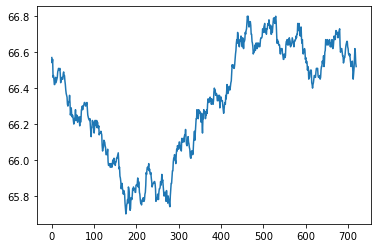

In [2]:
Y_avg = []
for reward_idx in range(len(Y)-250):
    Y_avg.append(round(sum(Y[reward_idx:reward_idx+250])/250,2))
plt.plot(Y_avg)

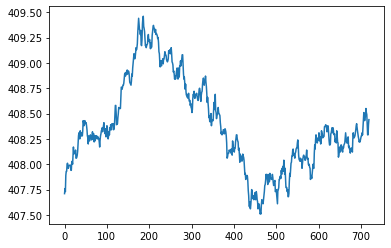

In [3]:
Z_avg = []
for reward_idx in range(len(Z)-250):
    Z_avg.append(round(sum(Z[reward_idx:reward_idx+250])/250,2))
plt.plot(Z_avg)